In [1]:
import efel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy
from scipy.signal import find_peaks
from scipy import signal
from scipy import stats
from scipy.optimize import curve_fit

In [2]:
#use neo to import either voltage or current clamp data in the correct, scaled units!
def load_neo_file(file_name, **kwargs):
    import neo
    reader = neo.io.get_io(file_name)
    blocks = reader.read(**kwargs)
    new_blocks = []
    for bl in blocks:
        new_segments = []
        for seg in bl.segments:
            traces = []
            count_traces = 0
            analogsignals = seg.analogsignals

            for sig in analogsignals:
                traces.append({})
                traces[count_traces]['T'] = sig.times.rescale('ms').magnitude
                #need to write an if statement here for conversion
                try:
                    traces[count_traces]['A'] = sig.rescale('pA').magnitude
                except:
                    traces[count_traces]['V'] = sig.rescale('mV').magnitude
                count_traces += 1
            new_segments.append(traces)
        #new_blocks.append(efel_segments)
    return new_segments

def ahc_analysis_step_time(path, time_start, time_end, metadata):
    sample_rate = 20_000
    start_time = int(time_start * sample_rate)
    end_time = int(time_end * sample_rate)

    def monoExp(x, m, t, b):
        return m * np.exp(-t * x) + b

    def biExp(x, m1, t1, m2, t2, b):
        return m1 * np.exp(-t1 * x) + m2 * np.exp(-t2 * x) + b

    ahc_append = []
    ahc_auc_append = []

    ahc_max_amp_append = []
    auc_append = []
    tau_append = []
    ahc_max_amp_df_append = []
    os.chdir(path)
    file_names = sorted(os.listdir())
    for file_name in file_names:
        tabla = []
        if file_name.endswith(".axgd") or file_name.endswith(".axgx"):
            traces = load_neo_file(file_name)
            for sk_data in traces:
                for data in sk_data:
                    #this is for the first part of the A-current
                    times1 = data['T'][start_time:end_time]  #this is 16.101 to 16.213
                    amps1 = data['A'][start_time:end_time]
                    #plt.plot(times, amps) #inspect
                    baseline = np.mean(data['A'][39200:39800])  #define a baseline period from which to substract from
                    amps1 = amps1 - baseline  #subtract the baseline from the amplitudes of the first pulse

                    amps1_df = pd.DataFrame(amps1)  #we generated all the amps into a dataframe, check
                    flat_times = np.ndarray.flatten(
                        times1)  #we have all of the times into a flattened numpy array, check
                    tabla.append(amps1_df)  #and we appended all of the amps into a dataframe
                amps_concat = pd.concat(tabla,
                                        axis=1)  #this is correct - we put all the amps for a given trace into a dataframe
            #now we need to average those dataframes by row
            averaged_sk_trace = amps_concat.mean(
                axis=1)  #woohooo this is the averaged SK trace in a pd.DF, this is what we want to work with from here on out!
            #print(np.argmax(averaged_sk_trace)) #this is the index of the max value of the averaged trace

            flat_times = flat_times[
                         np.argmax(averaged_sk_trace):]  #this is the times from the max value to the end of the trace
            averaged_sk_trace = averaged_sk_trace[np.argmax(
                averaged_sk_trace):]  #this is the averaged trace from the max value to the end of the trace

            #Block of code of AHC Max Amp !
            ahc_max_amp = pd.DataFrame.max(
                averaged_sk_trace)  #max of the whole ahc, not just sk component, This is the value!!
            #figure out to how put this in a format that can be read and concatenated
            ahc_max_amp_array = np.array(ahc_max_amp, ndmin=2)  #these lines are new
            ahc_max_amp_df = pd.DataFrame(ahc_max_amp_array)
            ahc_max_amp_df['file_name'] = file_name  #adding a column to add the filename

            ahc_append.append(ahc_max_amp_df)  #Here!
            ahc_max_amp_concat_df = pd.concat(ahc_append)  #This is the variable for ahc

            #Block of code for AHC AUC
            averaged_sk_trace_as_np = averaged_sk_trace.to_numpy()
            flattened_average_sk_trace = np.ndarray.flatten(averaged_sk_trace_as_np)
            ahc_auc = np.trapz(flattened_average_sk_trace) / 1000  #this is the auc of the whole ahc
            #bit of code to get the ahc auc into readable condition
            ahc_auc_array = np.array(ahc_auc, ndmin=2)
            ahc_auc_df = pd.DataFrame(ahc_auc_array)  #here we have the auc data in a dataframe
            ahc_auc_df['file_name'] = file_name
            ahc_auc_append.append(ahc_auc_df)
            ahc_auc_concat_df = pd.concat(ahc_auc_append)  #this is the variable for auc
            plt.plot(flat_times, averaged_sk_trace)  #check
            plt.fill_between(flat_times, 0, flattened_average_sk_trace, color='gray', alpha=0.5, label='AUC')

            #Block of code for kinetics
            trace_for_kinetics = flattened_average_sk_trace[:]
            times_rel = flat_times - flat_times[0]
            times_for_kinetics = times_rel[:]
            trace_for_kinetics_pd = pd.DataFrame(trace_for_kinetics)
            #trace_for_kinetics_pd.to_excel("trace_for_kinetics_pd.xlsx")
            times_for_kinetics_pd = pd.DataFrame(times_for_kinetics)
            #times_for_kinetics_pd.to_excel("times_for_kinetics_pd.xlsx")

            #fit the curve for inactivation tau
            # p0 = [500, .001, 50]  #values near what we expect   #here
            # params, cv = scipy.optimize.curve_fit(monoExp, times_for_kinetics, trace_for_kinetics, p0,
            #                                       bounds=(-np.inf, np.inf),
            #                                       maxfev=100000)  #here  #this fits the training curve with an r-squared of 0.97
            # m, t, b = params  #here

            # p0 = [500, .001, 500, .001, 50]  # initial parameter values
            # params, cv = scipy.optimize.curve_fit(biExp, times_for_kinetics, trace_for_kinetics, p0,
            #                                       bounds=(-np.inf, np.inf),
            #                                       maxfev=100000000)  # fitting the curve
            # m1, t1, m2, t2, b = params
            #
            # #plot results
            # plt.plot(times_for_kinetics, trace_for_kinetics, '.', label="data")
            # plt.plot(times_for_kinetics, biExp(times_for_kinetics, m1, t1, m2, t2, b), '--', label="fitted")
            # plt.title("Fitted Biexponential Curve")
            # plt.legend()
            # plt.show()
            #m, t = params
            sampleRate = 20_000  #hz
            # tauSec = (1 / t) / sampleRate
            # print(tauSec)
    #
    #         #determine quality of fit
    #         squaredDiffs = np.square(trace_for_kinetics - monoExp(times_for_kinetics, m, t, b))  #here
    #         squaredDiffsFromMean = np.square(trace_for_kinetics - np.mean(trace_for_kinetics))
    #         rSquared = 1 - np.sum(squaredDiffs) / np.sum(
    #             squaredDiffsFromMean)  #we want these, but they arent super important to display
    #         #print(f"R^2 = {rSquared}")
    #
    # #plot results
    # plt.plot(times_for_kinetics, trace_for_kinetics, '.', label="data")
    # plt.plot(times_for_kinetics, monoExp(times_for_kinetics, m, t, b), '--', label="fitted")  #here
    # plt.show()
    # plt.title("Fitted Expotential Curve")
    #
    #         #inspect the params
    #         #print(f"Y = {m} * e^(-{t} * x) + {b}")   #the equations are important
    #         #print(f"Tau = {tauSec * 1e6} us")    #but the tau is the most important
    #         plt.show()
    #         tau_flat_ms = tauSec * 1e4
    #
    #         #Bit of code to get tau into working order
    #         if 0 <= tauSec*1e4 <= 300:
    #             tau_array = np.array(tauSec * 1e4, ndmin=2)
    #             tau_df = pd.DataFrame(tau_array)
    #             tau_df['file_name'] = file_name
    #             tau_append.append(tau_df)
    #             tau_concat_df = pd.concat(tau_append)   #this is the variable for tau
    #         else:
    #             print(file_name + ' is not within the range of 0-300ms')
    #
    #lets rename columns and export to excel for each of our metrics
    ahc_max_amp_concat_df.rename(columns={0: 'Control AHC Max_Amplitude (pA)'}, inplace=True)
    ahc_max_amp_concat_df.to_excel('ahc_max_amp ' + metadata + '.xlsx', index=False)

    ahc_auc_concat_df.rename(columns={0: 'Control AHC AUC (pA*s)'}, inplace=True)
    ahc_auc_concat_df.to_excel('ahc_auc ' + metadata + '.xlsx', index=False)
    #
    # tau_concat_df.rename(columns = {0:'Control Decay Tau (ms)'}, inplace=True)
    # tau_concat_df.to_excel('ahc_tau ' + metadata + '.xlsx', index=False)
    #
    return display(ahc_max_amp_concat_df), display(ahc_auc_concat_df)  #, display(tau_concat_df)

,Control AHC Max_Amplitude (pA),file_name
0,317.915039,210708 005.axgd
0,1304.515381,210708 039.axgd
0,213.601166,210708 046.axgd
0,206.931076,210708 060.axgd


,Control AHC AUC (pA*s),file_name
0,204.978312,210708 005.axgd
0,226.862109,210708 039.axgd
0,108.372180,210708 046.axgd
0,144.853516,210708 060.axgd


(None, None)

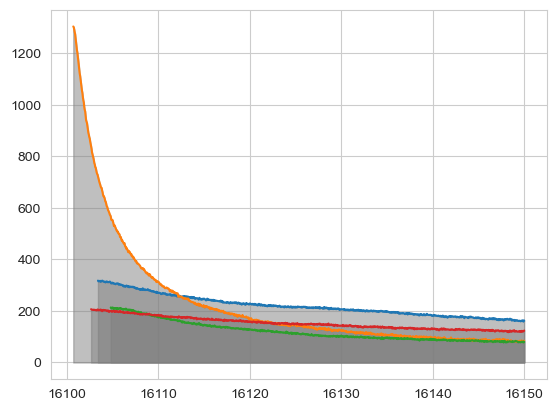

In [5]:
#these are the code to analyze the SK currents, an example of the voltage clamp data analysis. It will output the AHC max amplitude and AUC dor the entire tail current from the maximum point of the SK current to a specified end time. 

ahc_analysis_step_time(os.getcwd(), 16.1001, 16.15, '100ms step test')